In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
# Load the dataset
# parse_dates=['date']: This tells pandas to parse the 'Date' column as datetime.
# index_col='date': Sets the 'Date' column as the index of the DataFrame, which is useful for time series analysis.
df = pd.read_csv('exchange_rate.csv', parse_dates=['date'],dayfirst=True, index_col='date')
df.head()

,Ex_rate
date,
1990-01-01,0.7855
1990-01-02,0.7818
1990-01-03,0.7867
1990-01-04,0.7860
1990-01-05,0.7849


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7588 entries, 01-01-1990 00:00 to 10-10-2010 00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ex_rate  7588 non-null   float64
dtypes: float64(1)
memory usage: 118.6+ KB


In [6]:
df.describe()

,Ex_rate
count,7588.000000
mean,0.776974
std,0.136620
min,0.483297
25%,0.701422
50%,0.761377
75%,0.873477
max,1.102536


#### 2.	Initial Exploration: Plot the time series for currency to understand their trends, seasonality, and any anomalies.

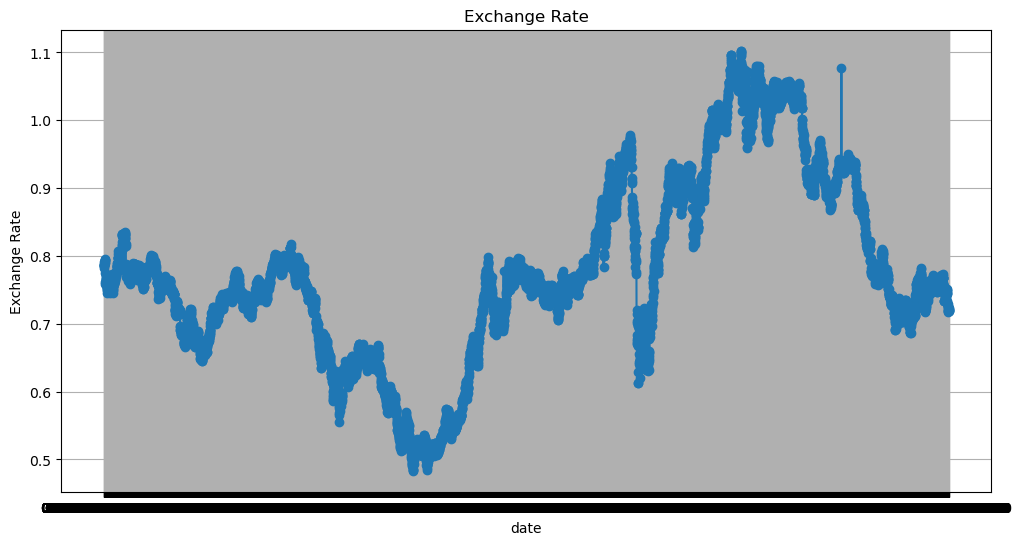

In [8]:
# Plot the time series for the exchange rate
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Ex_rate'], marker='o')
plt.title('Exchange Rate')
plt.xlabel('date')
plt.ylabel('Exchange Rate')
plt.grid(True)
plt.show()

In [9]:
df.isnull().sum()

Ex_rate    0
dtype: int64

##### Data dont have any missiong value or null value 

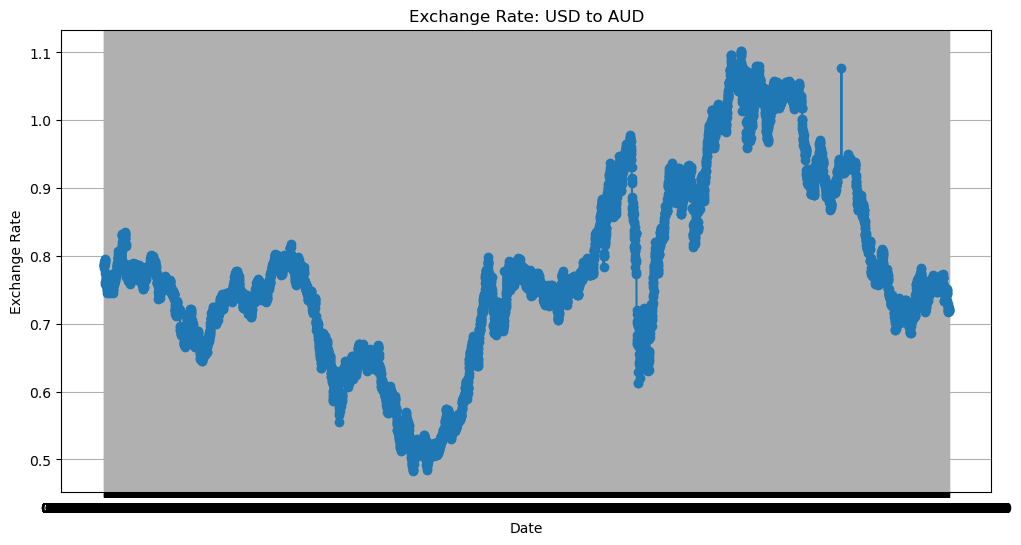

In [11]:
# Plot the time series for the exchange rate
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Ex_rate'], marker='o')
plt.title('Exchange Rate: USD to AUD')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.grid(True)
plt.show()


### Part 2: Model Building - ARIMA
##### Task 1: Parameter Selection for ARIMA

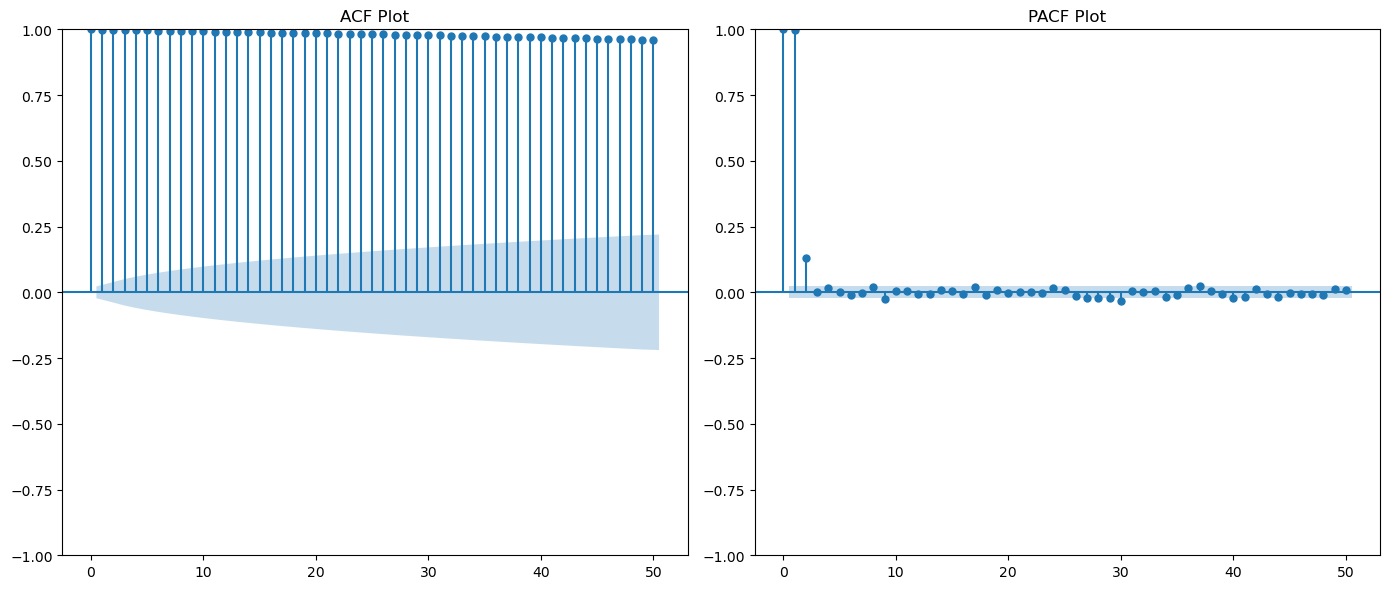

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
plt.figure(figsize=(14, 6))

# ACF Plot
plt.subplot(1, 2, 1)
plot_acf(df['Ex_rate'], lags=50, ax=plt.gca())
plt.title('ACF Plot')

# PACF Plot
plt.subplot(1, 2, 2)
plot_pacf(df['Ex_rate'], lags=50, ax=plt.gca())
plt.title('PACF Plot')

plt.tight_layout()
plt.show()


##### Task 2: Model Fitting


In [46]:
from statsmodels.tsa.arima.model import ARIMA
# Define the ARIMA model with estimated parameters (p, d, q)
p, d, q = 1, 1, 1  # Example parameters

# Fit the ARIMA model
model = ARIMA(df['Ex_rate'], order=(p, d, q))
model_fit = model.fit()

# Display model summary
print(model_fit.summary())

# Define the number of steps to forecast
forecast_steps = 90  # Example: forecasting 90 days ahead

# Forecast future values
forecast_arima = model_fit.get_forecast(steps=forecast_steps).predicted_mean

# Create a new index for the forecast
forecast_index_arima = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
forecast_arima_df = pd.DataFrame({'Date': forecast_index_arima, 'Forecast': forecast_arima})


C:\Users\ASHISH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\ASHISH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\ASHISH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Sat, 14 Sep 2024   AIC                         -56102.322
Time:                        17:53:33   BIC                         -56081.519
Sample:                    01-01-1990   HQIC                        -56095.182
                         - 10-10-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

#### Task 3: Diagnostics

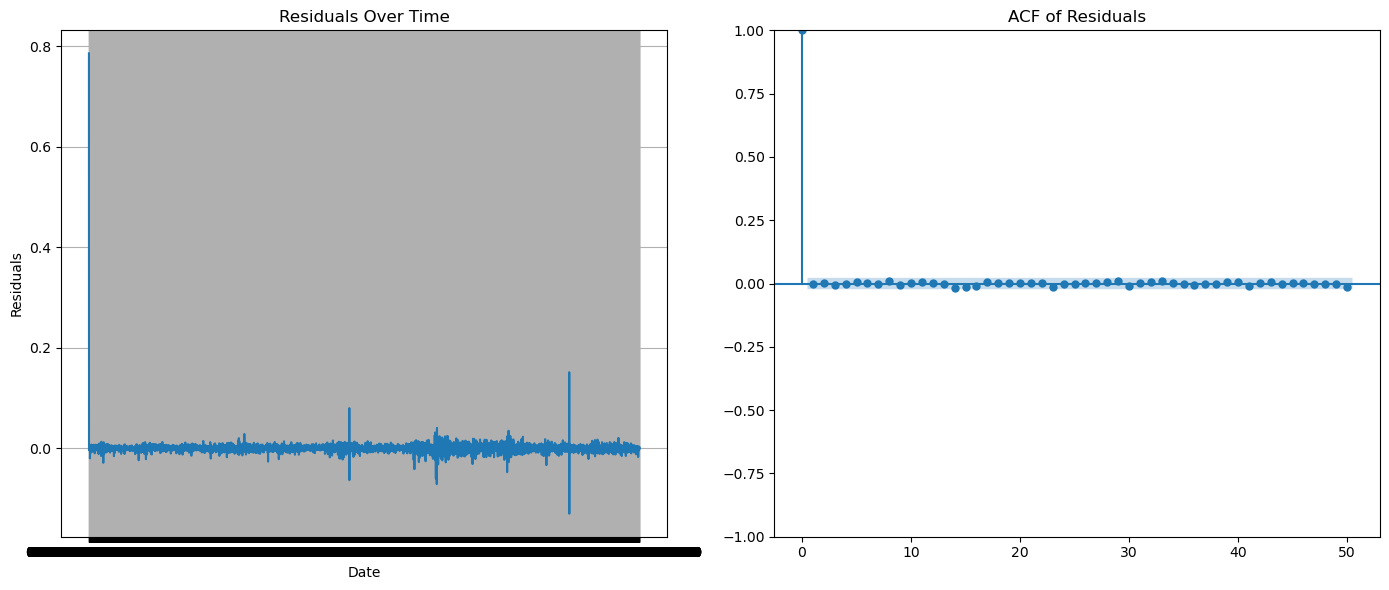

    lb_stat  lb_pvalue
10  1.81673   0.997562


In [17]:
# Get the residuals
residuals = model_fit.resid

# Plot residuals
plt.figure(figsize=(14, 6))

# Plot residuals over time
plt.subplot(1, 2, 1)
plt.plot(residuals)
plt.title('Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.grid(True)

# Plot ACF of residuals
plt.subplot(1, 2, 2)
plot_acf(residuals, lags=50, ax=plt.gca())
plt.title('ACF of Residuals')

plt.tight_layout()
plt.show()

# Perform the Ljung-Box test
from statsmodels.stats.diagnostic import acorr_ljungbox
ljung_box_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(ljung_box_test)


C:\Users\ASHISH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ASHISH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


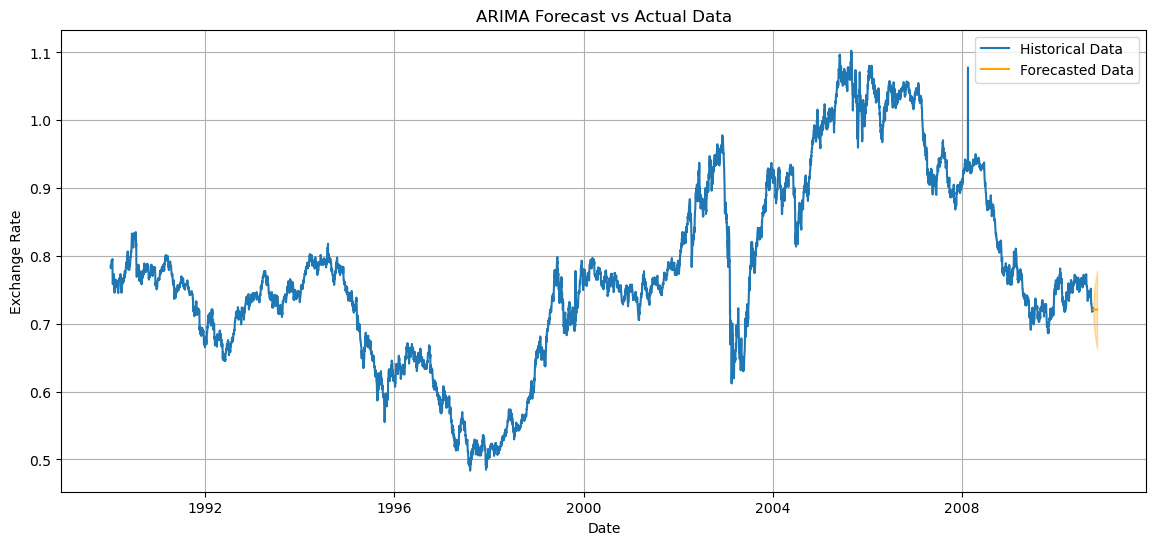

In [22]:
# Define the number of steps to forecast
forecast_steps = 30  # Example: forecasting 30 days ahead

# Generate forecasted values
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Generate future date range
forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

# Plot actual vs forecasted values
plt.figure(figsize=(14, 6))

# Plot historical data
plt.plot(df.index, df['Ex_rate'], label='Historical Data')

# Plot forecasted data
plt.plot(forecast_index, forecast_values, label='Forecasted Data', color='orange')

# Plot confidence intervals
plt.fill_between(forecast_index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='orange', alpha=0.3)

plt.title('ARIMA Forecast vs Actual Data')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

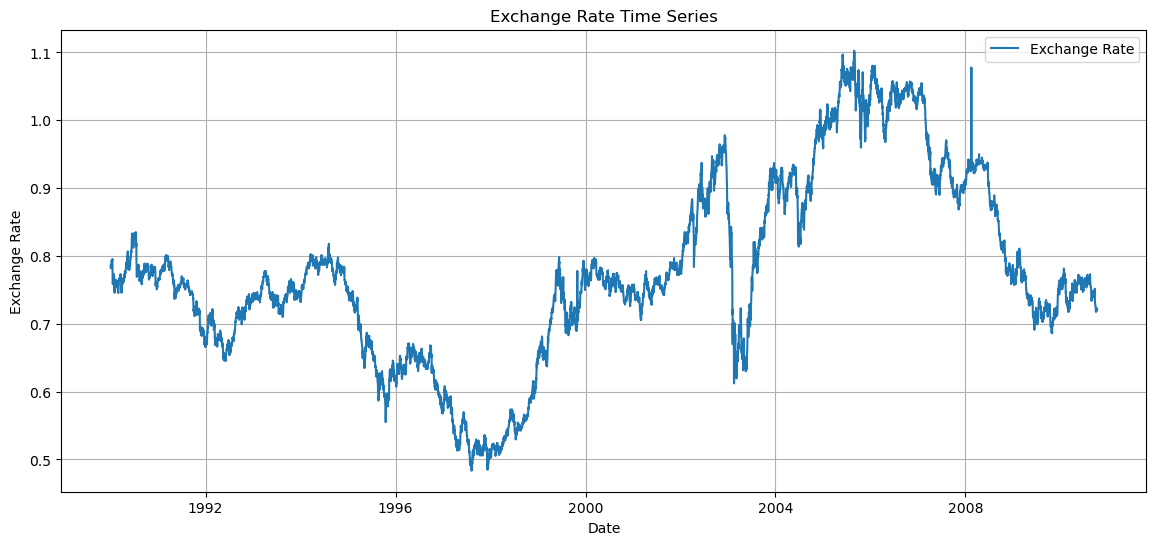

In [24]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Plot time series to determine characteristics
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['Ex_rate'], label='Exchange Rate')
plt.title('Exchange Rate Time Series')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\ASHISH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


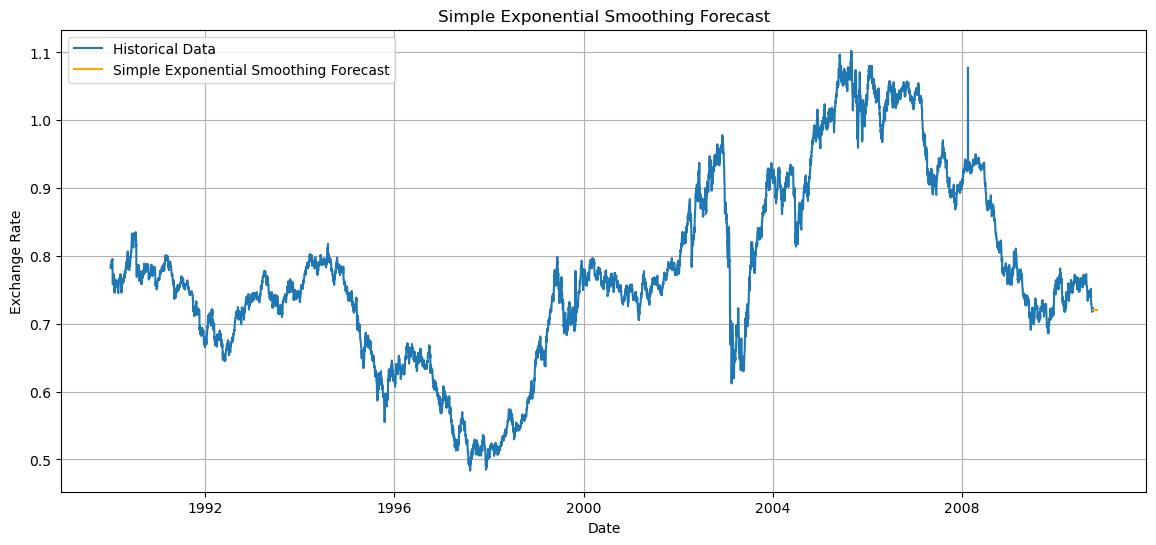

In [26]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# Fit the Simple Exponential Smoothing model
model_simple = SimpleExpSmoothing(df['Ex_rate']).fit()
forecast_simple = model_simple.forecast(steps=30)

# Plot forecast
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['Ex_rate'], label='Historical Data')
plt.plot(forecast_simple.index, forecast_simple, label='Simple Exponential Smoothing Forecast', color='orange')
plt.title('Simple Exponential Smoothing Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()


##### 1. Simple Exponential Smoothing

C:\Users\ASHISH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


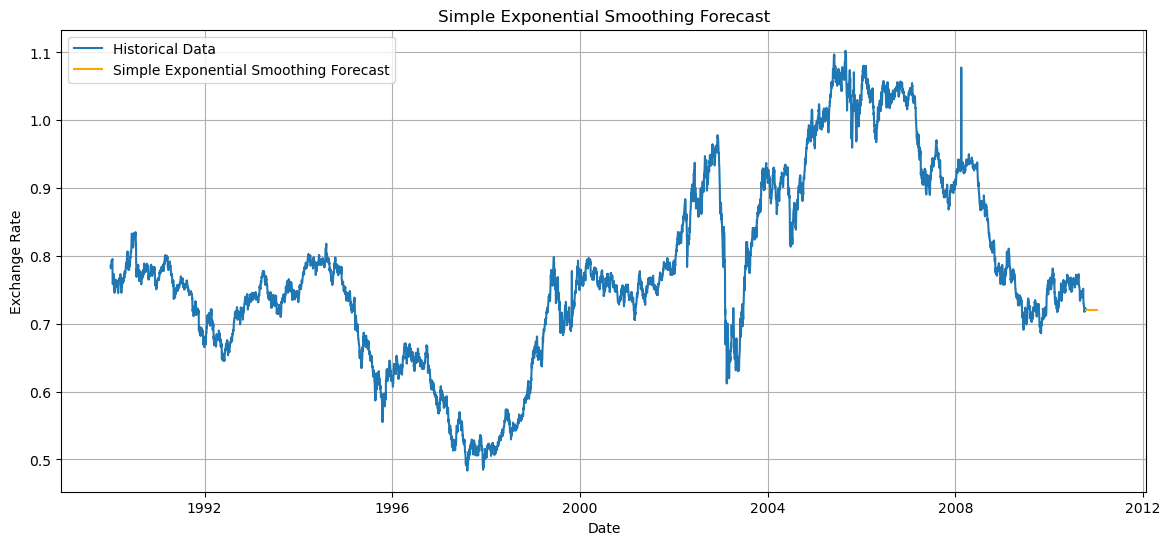

In [29]:
# Define the number of steps to forecast
forecast_steps = 90  # Extended forecast period (e.g., 90 days)

# Fit the Simple Exponential Smoothing model
model_simple = SimpleExpSmoothing(df['Ex_rate']).fit()
forecast_simple = model_simple.forecast(steps=forecast_steps)

# Create a new index for the forecast
forecast_index_simple = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

# Plot forecast
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['Ex_rate'], label='Historical Data')
plt.plot(forecast_index_simple, forecast_simple, label='Simple Exponential Smoothing Forecast', color='orange')
plt.title('Simple Exponential Smoothing Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()


##### 2. Holt’s Linear Trend

C:\Users\ASHISH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


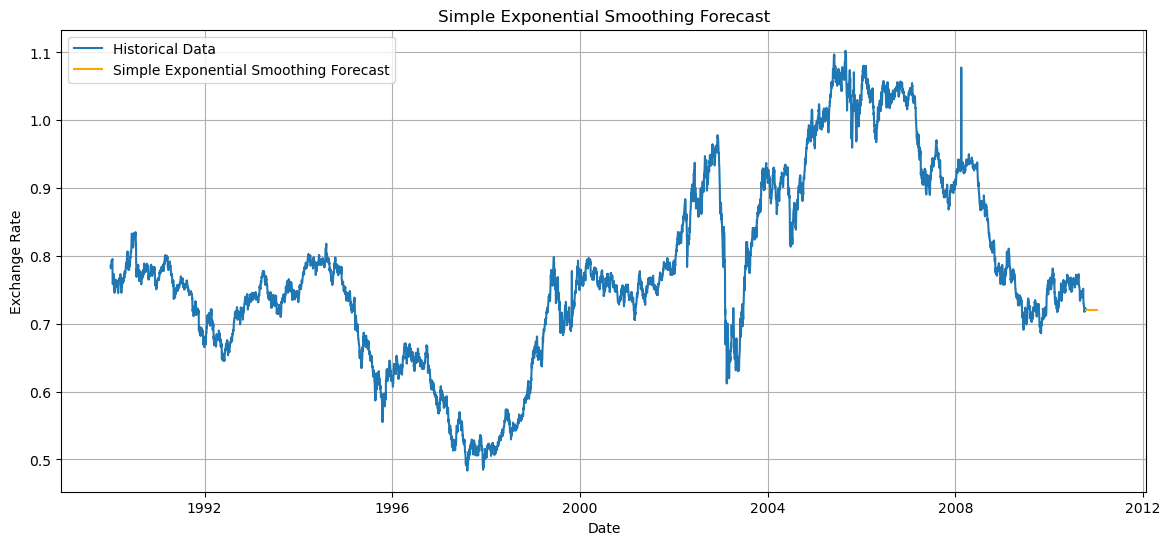

In [36]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# Define the number of steps to forecast
forecast_steps = 90  # Extended forecast period (e.g., 90 days)

# Fit the Simple Exponential Smoothing model
model_simple = SimpleExpSmoothing(df['Ex_rate']).fit()
forecast_simple = model_simple.forecast(steps=forecast_steps)

# Create a new index for the forecast
forecast_index_simple = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

# Plot forecast
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['Ex_rate'], label='Historical Data')
plt.plot(forecast_index_simple, forecast_simple, label='Simple Exponential Smoothing Forecast', color='orange')
plt.title('Simple Exponential Smoothing Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\ASHISH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\ASHISH\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


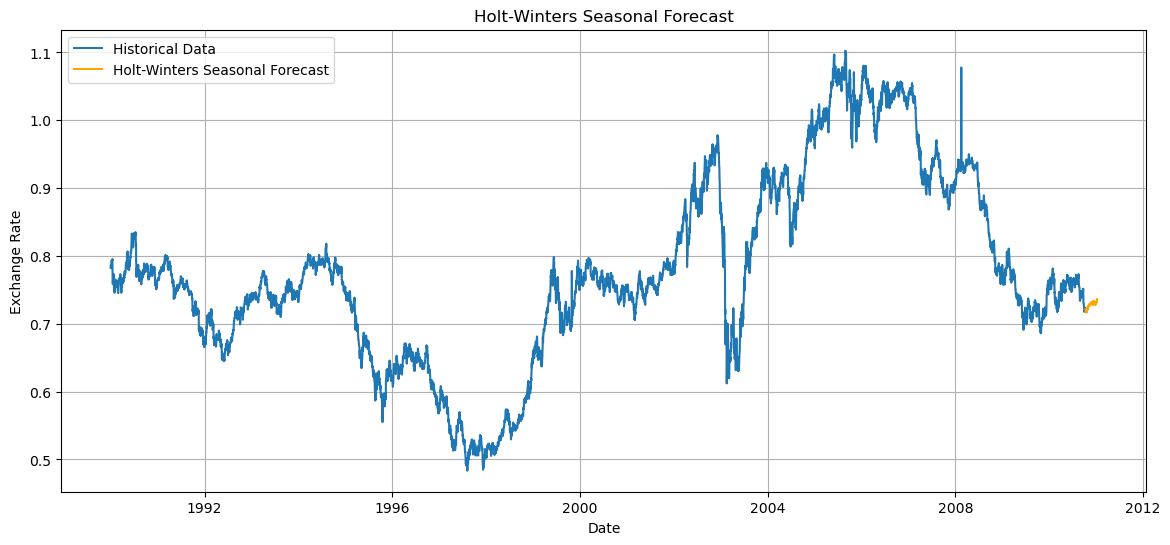

In [34]:
# Define the number of steps to forecast
forecast_steps = 90  # Extended forecast period (e.g., 90 days)

# Fit the Holt-Winters Seasonal model
model_hw = ExponentialSmoothing(df['Ex_rate'], seasonal='add', seasonal_periods=365).fit()
forecast_hw = model_hw.forecast(steps=forecast_steps)

# Create a new index for the forecast
forecast_index_hw = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

# Plot forecast
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['Ex_rate'], label='Historical Data')
plt.plot(forecast_index_hw, forecast_hw, label='Holt-Winters Seasonal Forecast', color='orange')
plt.title('Holt-Winters Seasonal Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()


### In the graph the values of forecasting is so small that we cannot see directly That is why i printed it here 

In [38]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# Define the number of steps to forecast
forecast_steps = 90  # Extended forecast period (e.g., 90 days)

# Fit the Simple Exponential Smoothing model
model_simple = SimpleExpSmoothing(df['Ex_rate']).fit()
forecast_simple = model_simple.forecast(steps=forecast_steps)

# Create a new index for the forecast
forecast_index_simple = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

# Display forecast values
forecast_simple_df = pd.DataFrame({'Date': forecast_index_simple, 'Forecast': forecast_simple})
print(forecast_simple_df)

                 Date  Forecast
2010-10-11 2010-10-11  0.720862
2010-10-12 2010-10-12  0.720862
2010-10-13 2010-10-13  0.720862
2010-10-14 2010-10-14  0.720862
2010-10-15 2010-10-15  0.720862
...               ...       ...
2011-01-04 2011-01-04  0.720862
2011-01-05 2011-01-05  0.720862
2011-01-06 2011-01-06  0.720862
2011-01-07 2011-01-07  0.720862
2011-01-08 2011-01-08  0.720862

[90 rows x 2 columns]


C:\Users\ASHISH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


#### 1. Model Selection:


* Simple Exponential Smoothing: Good for series without trend or seasonality.
* Holt’s Linear Trend: Extends Simple Exponential Smoothing to capture linear trends.
* Holt-Winters Seasonal: Suitable for series with both trend and seasonality.
##### Since i previously used Holt's Linear Trend, we'll proceed with that model. If you want to try another model, please let me know!
#### Holt’s Linear Trend Model

C:\Users\ASHISH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                 Date  Forecast
2010-10-11 2010-10-11  0.720590
2010-10-12 2010-10-12  0.720354
2010-10-13 2010-10-13  0.720118
2010-10-14 2010-10-14  0.719882
2010-10-15 2010-10-15  0.719646
...               ...       ...
2011-01-04 2011-01-04  0.700531
2011-01-05 2011-01-05  0.700295
2011-01-06 2011-01-06  0.700059
2011-01-07 2011-01-07  0.699823
2011-01-08 2011-01-08  0.699587

[90 rows x 2 columns]


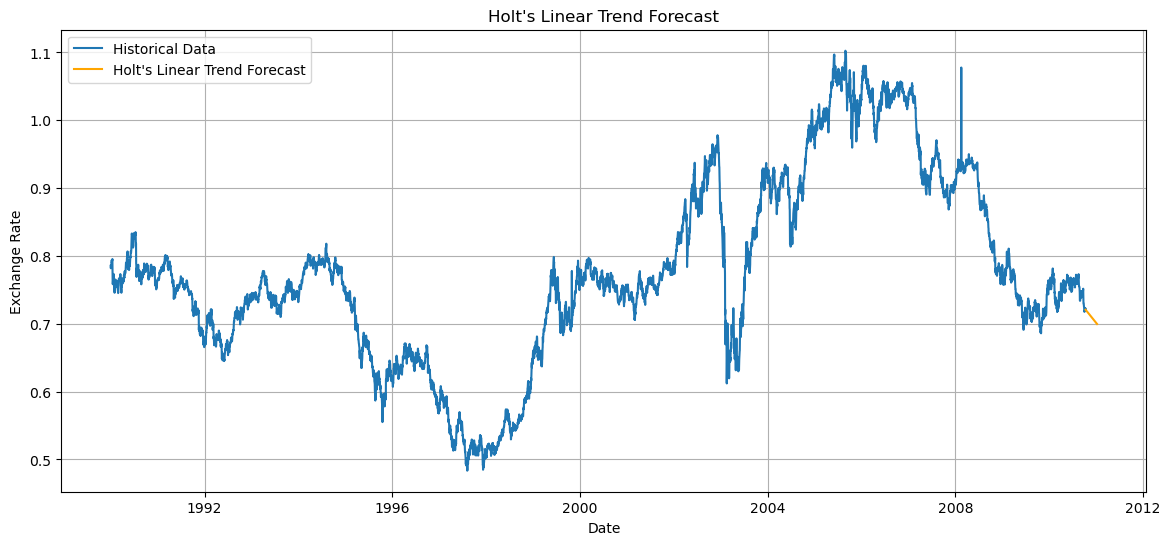

In [42]:
from statsmodels.tsa.holtwinters import Holt

# Define the number of steps to forecast
forecast_steps = 90  # Adjust as needed

# Fit the Holt's Linear Trend model
model_holt = Holt(df['Ex_rate']).fit()
forecast_holt = model_holt.forecast(steps=forecast_steps)

# Create a new index for the forecast
forecast_index_holt = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

# Display forecast values
forecast_holt_df = pd.DataFrame({'Date': forecast_index_holt, 'Forecast': forecast_holt})
print(forecast_holt_df)

# Plot forecast
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['Ex_rate'], label='Historical Data')
plt.plot(forecast_index_holt, forecast_holt, label='Holt\'s Linear Trend Forecast', color='orange')
plt.title('Holt\'s Linear Trend Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()


In [48]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Assuming forecast_arima_df has the forecasted values and you have actual values
# If you don't have actual future values, use the last historical values for demonstration purposes
# Replace with actual values if available
actual_values = df['Ex_rate'].iloc[-forecast_steps:].values

# Ensure forecast and actual values are aligned
forecast_values = forecast_arima_df['Forecast'].values

# Compute error metrics
mae_arima = mean_absolute_error(actual_values, forecast_values)
rmse_arima = np.sqrt(mean_squared_error(actual_values, forecast_values))
mape_arima = np.mean(np.abs((actual_values - forecast_values) / actual_values)) * 100

print("ARIMA Model Performance:")
print(f"MAE: {mae_arima:.4f}")
print(f"RMSE: {rmse_arima:.4f}")
print(f"MAPE: {mape_arima:.2f}%")


ARIMA Model Performance:
MAE: 0.0277
RMSE: 0.0315
MAPE: 3.66%


In [50]:
from statsmodels.tsa.holtwinters import Holt
import pandas as pd

# Define the number of steps to forecast
forecast_steps = 90  # Forecasting 90 days ahead

# Fit the Holt's Linear Trend model
model_holt = Holt(df['Ex_rate']).fit()

# Forecast future values
forecast_holt = model_holt.forecast(steps=forecast_steps)

# Create a new index for the forecast
forecast_index_holt = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
forecast_holt_df = pd.DataFrame({'Date': forecast_index_holt, 'Forecast': forecast_holt})

# Print forecast values
print("Holt's Linear Trend Forecast Values:")
print(forecast_holt_df.head())


C:\Users\ASHISH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Holt's Linear Trend Forecast Values:
                 Date  Forecast
2010-10-11 2010-10-11  0.720590
2010-10-12 2010-10-12  0.720354
2010-10-13 2010-10-13  0.720118
2010-10-14 2010-10-14  0.719882
2010-10-15 2010-10-15  0.719646


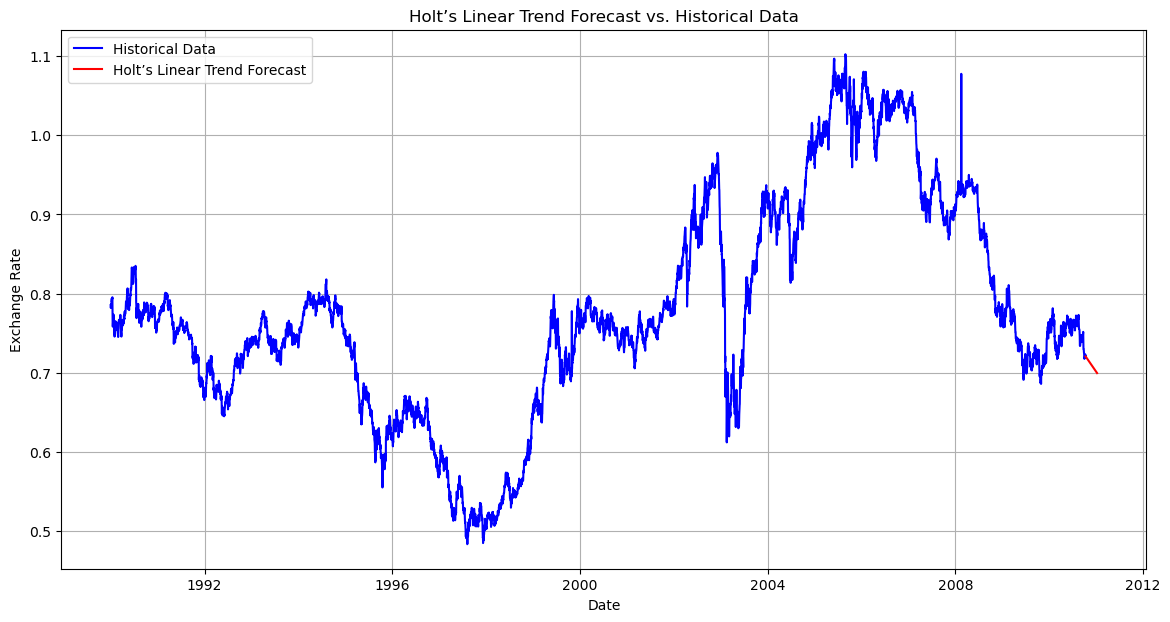

In [52]:
import matplotlib.pyplot as plt

# Plot the historical data
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Ex_rate'], label='Historical Data', color='blue')

# Plot the Holt’s Linear Trend forecast
plt.plot(forecast_holt_df['Date'], forecast_holt_df['Forecast'], label='Holt’s Linear Trend Forecast', color='red')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title('Holt’s Linear Trend Forecast vs. Historical Data')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


In [54]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Get the actual values from the end of the historical data
actual_values = df['Ex_rate'].iloc[-forecast_steps:].values

# Ensure forecast arrays are of the same length as actual values
forecast_arima = model_fit.forecast(steps=forecast_steps)
forecast_holt = forecast_holt_df['Forecast'].values

# Error metrics for ARIMA forecasts
mae_arima = mean_absolute_error(actual_values, forecast_arima)
rmse_arima = np.sqrt(mean_squared_error(actual_values, forecast_arima))
mape_arima = np.mean(np.abs((actual_values - forecast_arima) / actual_values)) * 100

# Error metrics for Holt's Linear Trend forecasts
mae_holt = mean_absolute_error(actual_values, forecast_holt)
rmse_holt = np.sqrt(mean_squared_error(actual_values, forecast_holt))
mape_holt = np.mean(np.abs((actual_values - forecast_holt) / actual_values)) * 100

# Print error metrics
print("ARIMA Model Performance:")
print(f"MAE: {mae_arima:.4f}")
print(f"RMSE: {rmse_arima:.4f}")
print(f"MAPE: {mape_arima:.2f}%")

print("\nHolt's Linear Trend Model Performance:")
print(f"MAE: {mae_holt:.4f}")
print(f"RMSE: {rmse_holt:.4f}")
print(f"MAPE: {mape_holt:.2f}%")


ARIMA Model Performance:
MAE: 0.0277
RMSE: 0.0315
MAPE: 3.66%

Holt's Linear Trend Model Performance:
MAE: 0.0381
RMSE: 0.0396
MAPE: 5.07%


## Model Comparison

#### ARIMA Model Performance:
* MAE: 0.0277
* RMSE: 0.0315
* MAPE: 3.66%
##### Holt's Linear Trend Model Performance:
* MAE: 0.0381
* RMSE: 0.0396
* MAPE: 5.07%
### Analysis

#### Accuracy:
* ARIMA has lower MAE, RMSE, and MAPE compared to Holt's Linear Trend model, indicating that the ARIMA model provides more accurate forecasts for this dataset.

#### Error Metrics:
* MAE (Mean Absolute Error): Measures the average magnitude of errors in the forecasts, with lower values indicating better performance. ARIMA has a lower MAE.
RMSE (Root Mean Squared Error): Measures the square root of the average of the squared errors, penalizing larger errors more heavily. ARIMA has a lower RMSE.
MAPE (Mean Absolute Percentage Error): Expresses forecast accuracy as a percentage. ARIMA has a lower MAPE.

#### Model Suitability:

* ARIMA might be better suited for this dataset due to its lower error metrics, which suggests it captures the underlying patterns in the time series more effectively.

### Conclusion
* ARIMA appears to be the better model for forecasting exchange rates in this dataset based on the lower error metrics.
* Holt’s Linear Trend model, while still providing useful forecasts, has higher error rates, suggesting it might not capture the underlying trends as effectively as ARIMA in this case.